In [1]:
import rasterio
import geopandas as gpd
import pandas as pd
import numpy as np
import folium
import matplotlib.colors as mcolors
from rasterio.plot import show
from rasterio.transform import rowcol

In [2]:
filepath = "/Users/richie/Projects/smart-green-city-konstanz/richards_notebooks/LCZ/data/messstationen_meta.csv"
mess_meta = pd.read_csv(filepath, sep=";")
mess_meta
print(mess_meta[['Geogr.Laenge', 'Geogr.Breite']].describe())

       Geogr.Laenge  Geogr.Breite
count     11.000000     11.000000
mean       9.179880     47.668770
std        0.019245      0.008217
min        9.147058     47.658239
25%        9.171379     47.662143
50%        9.177239     47.667215
75%        9.185754     47.673042
max        9.214489     47.682119


In [3]:
#Maja
import geopandas as gpd
import matplotlib.pyplot as plt

#LCZ-Raster laden (Koordinatenreferenzsystem: EPSG:4326)
lcz_path ="/Users/richie/Projects/smart-green-city-konstanz/richards_notebooks/LCZ/data/4381f9078b2704eac4c9ab8c1631439c4ccff939.tif"

#Kleinräumige Gliederung (?) 
geojson_path = "/Users/richie/Projects/smart-green-city-konstanz/majas_notebooks/Kleinräumige_Gliederung_4330766187849128049.geojson"

# Stadtteile von Konstanz laden (GeoJSON-Datei erforderlich)
stadtteile = gpd.read_file(geojson_path)

# raster laden
raster = rasterio.open(lcz_path)

named_coordinates = list(zip(mess_meta["name"],mess_meta["Geogr.Laenge"], mess_meta["Geogr.Breite"]))

# Koordinaten nutzen um Local Climate Zone Werte aus Raster zu extrahieren
results = []
for name,breite,länge in named_coordinates:
    # Koordinaten in Pixel (Zeile, Spalte) im Raster umwandeln
    row, col = rowcol(raster.transform, breite, länge)
    
    # LCZ-Wert an dieser Position auslesen
    lcz_value = raster.read(1)[row, col]
    
    # Ergebnis mit Namen speichern
    results.append({"Name": name, "Geografische Breite": breite, "Geografische Länge": länge, "LCZ_Class": lcz_value})

results

DataSourceError: /Users/richie/Projects/smart-green-city-konstanz/majas_notebooks/Kleinräumige_Gliederung_4330766187849128049.geojson: No such file or directory

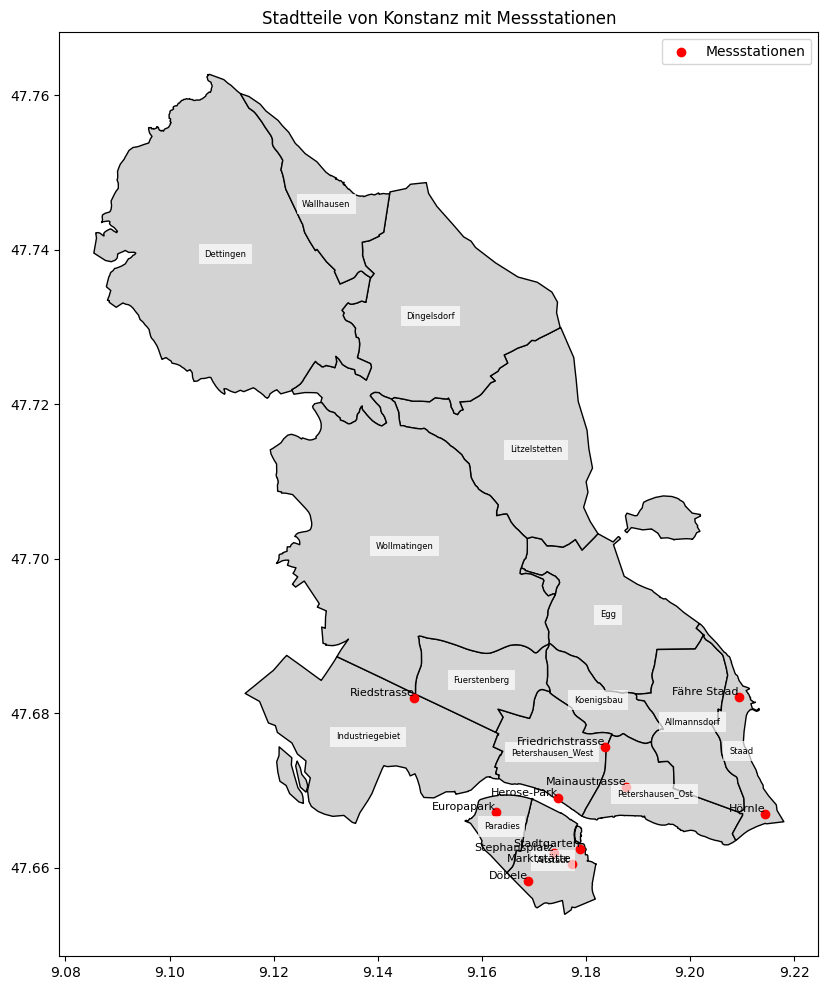

In [4]:

# 12 Beispielkoordinaten für Messstationen (müssen echte Werte ersetzt werden) # sind das nicht die echten Werte? 
messstationen = gpd.GeoDataFrame(
    mess_meta,
    geometry=gpd.points_from_xy(mess_meta["Geogr.Laenge"], mess_meta["Geogr.Breite"]),
    crs="EPSG:4326"
)

# Karte erstellen
fig, ax = plt.subplots(figsize=(10, 12))
stadtteile.plot(ax=ax, color="lightgrey", edgecolor="black")
# Stadtteilnamen hinzufügen
for idx, row in stadtteile.iterrows():
    centroid = row.geometry.centroid
    ax.text(centroid.x, centroid.y, row["STT_NAME"], fontsize=6, ha='center', va='center', color='black', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))


messstationen.plot(ax=ax, color="red", marker="o", label="Messstationen")
for idx, row in messstationen.iterrows():
    ax.text(row.geometry.x, row.geometry.y, row["name"], fontsize=8, ha='right', va='bottom', color='black')

# Titel und Legende
ax.set_title("Stadtteile von Konstanz mit Messstationen")
plt.legend()
plt.show()


In [ ]:
print(messstationen.geometry.type)

In [ ]:
print(messstationen.geometry.geom_type.unique())

In [6]:
#ChatGPT überlappen
import folium
import rasterio
import geopandas as gpd
import numpy as np
from rasterio.plot import show
from folium.plugins import MousePosition

# 📌 1. LCZ-Raster öffnen & speichern als PNG für Overlay

png_path = "lcz_overlay.png"

with rasterio.open(lcz_path) as src:
    lcz_data = src.read(1)
    lcz_transform = src.transform
    bounds = src.bounds

    # Farbschema für das Raster
    import matplotlib.pyplot as plt
    import matplotlib.colors as mcolors
    
    lcz_colors = {
        1: "#8B0000", 2: "#FF4500", 3: "#FFD700",
        4: "#228B22", 5: "#00FA9A", 6: "#00CED1",
        7: "#1E90FF", 8: "#4169E1", 9: "#8A2BE2",
        10: "#A52A2A", 11: "#006400", 12: "#32CD32",
        13: "#ADFF2F", 14: "#FFFF00", 15: "#D3D3D3",
        16: "#DEB887", 17: "#4682B4"
    }

    cmap = mcolors.ListedColormap([lcz_colors[i] for i in sorted(lcz_colors.keys())])
    bounds_values = np.arange(1, 18)
    norm = mcolors.BoundaryNorm(bounds_values, cmap.N)

    # Speichern des Rasters als PNG
    fig, ax = plt.subplots(figsize=(10, 10))
    show(lcz_data, transform=lcz_transform, cmap=cmap, norm=norm, ax=ax)
    plt.axis("off")
    plt.savefig(png_path, bbox_inches="tight", pad_inches=0, dpi=300)
    plt.close()

# 📌 2. Folium-Karte erstellen
m = folium.Map(location=[(bounds.top + bounds.bottom) / 2, (bounds.left + bounds.right) / 2], zoom_start=12)

# 📌 3. Raster als Bild-Overlay einfügen
image_overlay = folium.raster_layers.ImageOverlay(
    image=png_path,
    bounds=[[bounds.bottom, bounds.left], [bounds.top, bounds.right]],
    opacity=0.6,
    interactive=True
)
image_overlay.add_to(m)

# 📌 4. Stadtteile & Messstationen hinzufügen
stadtteile = gpd.read_file(geojson_path)
#messstationen = gpd.read_file(geojson_path)

# Stadtteile als Layer
folium.GeoJson(stadtteile, name="Stadtteile", style_function=lambda x: {"color": "black", "weight": 1}).add_to(m)

# Messstationen als Marker hinzufügen
for _, row in messstationen.iterrows():
    folium.Marker(
        location=[row.geometry.y, row.geometry.x],
        popup=row["name"],
        icon=folium.Icon(color="red", icon="info-sign")
    ).add_to(m)

# 📌 5. Zusätzliche Funktionen: Mausposition & Layer-Kontrolle
MousePosition().add_to(m)
folium.LayerControl().add_to(m)

# 📌 6. Karte anzeigen
m.save("interaktive_karte.html")

In [4]:
import folium
import rasterio
import geopandas as gpd
import numpy as np
from rasterio.plot import show
from folium.plugins import MousePosition
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# 📌 1. LCZ-Raster öffnen & speichern als PNG für Overlay
png_path = "lcz_overlay.png"

lcz_colors = {
    1: "#8B0000", 2: "#FF4500", 3: "#FFD700",
    4: "#228B22", 5: "#00FA9A", 6: "#00CED1",
    7: "#1E90FF", 8: "#4169E1", 9: "#8A2BE2",
    10: "#A52A2A", 11: "#006400", 12: "#32CD32",
    13: "#ADFF2F", 14: "#FFFF00", 15: "#D3D3D3",
    16: "#DEB887", 17: "#4682B4"
}

with rasterio.open(lcz_path) as src:
    lcz_data = src.read(1)
    lcz_transform = src.transform
    bounds = src.bounds
    
    cmap = mcolors.ListedColormap([lcz_colors[i] for i in sorted(lcz_colors.keys())])
    bounds_values = np.arange(1, 18)
    norm = mcolors.BoundaryNorm(bounds_values, cmap.N)
    
    fig, ax = plt.subplots(figsize=(10, 10))
    show(lcz_data, transform=lcz_transform, cmap=cmap, norm=norm, ax=ax)
    plt.axis("off")
    plt.savefig(png_path, bbox_inches="tight", pad_inches=0, dpi=300)
    plt.close()

# 📌 2. Folium-Karte erstellen
m = folium.Map(location=[(bounds.top + bounds.bottom) / 2, (bounds.left + bounds.right) / 2], zoom_start=12)

# 📌 3. Raster als Bild-Overlay einfügen
image_overlay = folium.raster_layers.ImageOverlay(
    image=png_path,
    bounds=[[bounds.bottom, bounds.left], [bounds.top, bounds.right]],
    opacity=0.6,
    interactive=True
)
image_overlay.add_to(m)

# 📌 4. Stadtteile & Messstationen hinzufügen
stadtteile = gpd.read_file(geojson_path)
folium.GeoJson(stadtteile, name="Stadtteile", style_function=lambda x: {"color": "black", "weight": 1}).add_to(m)

for _, row in messstationen.iterrows():
    folium.Marker(
        location=[row.geometry.y, row.geometry.x],
        popup=row["name"],
        icon=folium.Icon(color="red", icon="info-sign")
    ).add_to(m)

# 📌 5. Legende für LCZ hinzufügen
def add_legend(map_object, title, color_dict):
    legend_html = '<div style="position: fixed; bottom: 50px; left: 50px; z-index: 1000; background: white; padding: 10px; border-radius: 5px; box-shadow: 2px 2px 5px rgba(0,0,0,0.3);">'
    legend_html += f'<b>{title}</b><br>'
    for key, color in color_dict.items():
        legend_html += f'<i style="background: {color}; width: 10px; height: 10px; display: inline-block; margin-right: 5px;"></i> LCZ {key}<br>'
    legend_html += '</div>'
    
    map_object.get_root().html.add_child(folium.Element(legend_html))

add_legend(m, "LCZ-Farben", lcz_colors)

# 📌 6. Zusätzliche Funktionen: Mausposition & Layer-Kontrolle
MousePosition().add_to(m)
folium.LayerControl().add_to(m)

# 📌 7. Karte speichern
m.save("interaktive_karte_m_leg.html")

DataSourceError: /Users/richie/Projects/smart-green-city-konstanz/majas_notebooks/Kleinräumige_Gliederung_4330766187849128049.geojson: No such file or directory